# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=False, 
    download=True,
    transform=transform
)

10000
torch.Size([1, 28, 28]) 7


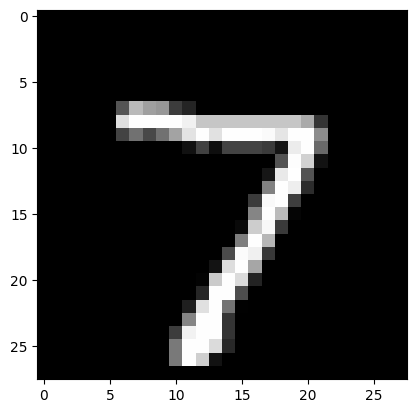

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [12]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# 데이터셋 크기 확인
dataset_size = len(trainset) 

batch_size = 64
# 훈련과 검증 인덱스 설정 (전체 크기 내에서 설정)
split_point = int(0.8 * dataset_size)  # 80%를 훈련용, 20%를 검증용으로 나눔
train_indices = list(range(split_point))  # 0부터 split_point-1까지
test_indices = list(range(split_point, dataset_size))  # split_point부터 끝까지

# Subset을 사용하여 훈련 및 검증 데이터셋 나누기
train_dataset = Subset(trainset, train_indices)
test_dataset = Subset(trainset, test_indices)

# DataLoader로 배치 처리
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [16]:
import torch
import torch.nn as nn
from torch.optim import SGD

# Model 클래스 정의
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 입력층 -> 은닉층
        self.fc2 = nn.Linear(hidden_size, output_size)  # 은닉층 -> 출력층
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # 28x28 이미지 -> 1차원 벡터로 변환
        x = self.fc1(x)  # 첫 번째 레이어 적용
        x = torch.relu(x)  # ReLU 활성화 함수
        x = self.fc2(x)  # 두 번째 레이어 적용
        return x

# 모델 초기화
input_size = 28 * 28  # MNIST 이미지 크기
hidden_size = 1024  # 은닉층 크기
output_size = 10  # MNIST 클래스 수

model = Model(input_size, hidden_size, output_size)

# 손실 함수 및 옵티마이저 정의

criterion = nn.CrossEntropyLoss()  # Cross-Entropy 손실 함수
optimizer = SGD(model.parameters(), lr=0.01)  # SGD 옵티마이저

# 학습 데이터 및 라벨 예시 (임의로 생성된 데이터)
data = torch.randn(64, 1, 28, 28)  # 배치 크기 64, 28x28 이미지
target = torch.randint(0, 10, (64,))  # 0~9 사이의 정수로 된 라벨 (64개의 샘플)

# 학습 과정
num_epochs = 100  # 학습 반복 횟수

for epoch in range(num_epochs):
    # Forward 패스: 모델 출력 계산
    output = model(data)
    
    # 손실 계산
    loss = criterion(output, target)
    
    # 모델 학습 과정
    optimizer.zero_grad()  # 기존의 그라디언트를 초기화
    loss.backward()  # 손실 함수에 대한 그라디언트 계산
    optimizer.step()  # 모델 매개변수 업데이트
    
    # 예측 정확도 계산
    _, predicted = torch.max(output, 1)  # 가장 높은 값의 인덱스를 예측 값으로 선택
    correct = (predicted == target).sum().item()  # 맞춘 개수
    accuracy = correct / target.size(0)  # 정확도 계산
    
    # 에포크마다 손실과 정확도 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%')


Epoch [1/100], Loss: 2.3246, Accuracy: 10.94%
Epoch [2/100], Loss: 2.2831, Accuracy: 12.50%
Epoch [3/100], Loss: 2.2426, Accuracy: 12.50%
Epoch [4/100], Loss: 2.2032, Accuracy: 18.75%
Epoch [5/100], Loss: 2.1648, Accuracy: 23.44%
Epoch [6/100], Loss: 2.1272, Accuracy: 32.81%
Epoch [7/100], Loss: 2.0904, Accuracy: 37.50%
Epoch [8/100], Loss: 2.0544, Accuracy: 45.31%
Epoch [9/100], Loss: 2.0190, Accuracy: 51.56%
Epoch [10/100], Loss: 1.9843, Accuracy: 57.81%
Epoch [11/100], Loss: 1.9502, Accuracy: 59.38%
Epoch [12/100], Loss: 1.9167, Accuracy: 62.50%
Epoch [13/100], Loss: 1.8837, Accuracy: 68.75%
Epoch [14/100], Loss: 1.8513, Accuracy: 71.88%
Epoch [15/100], Loss: 1.8193, Accuracy: 73.44%
Epoch [16/100], Loss: 1.7878, Accuracy: 79.69%
Epoch [17/100], Loss: 1.7568, Accuracy: 79.69%
Epoch [18/100], Loss: 1.7262, Accuracy: 87.50%
Epoch [19/100], Loss: 1.6961, Accuracy: 89.06%
Epoch [20/100], Loss: 1.6664, Accuracy: 89.06%
Epoch [21/100], Loss: 1.6371, Accuracy: 90.62%
Epoch [22/100], Loss: 

In [17]:
import torch
import torch.nn as nn
from torch.optim import SGD

# Model 클래스 정의
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 입력층 -> 은닉층
        self.fc2 = nn.Linear(hidden_size, output_size)  # 은닉층 -> 출력층
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # 28x28 이미지 -> 1차원 벡터로 변환
        x = self.fc1(x)  # 첫 번째 레이어 적용
        x = torch.relu(x)  # ReLU 활성화 함수
        x = self.fc2(x)  # 두 번째 레이어 적용
        return x

# 모델 초기화
input_size = 28 * 28  # MNIST 이미지 크기
hidden_size = 1024  # 은닉층 크기
output_size = 10  # MNIST 클래스 수

model = Model(input_size, hidden_size, output_size)



In [27]:
from torch.optim import SGD
# 옵티마이저 설정
lr = 0.001
criterion = nn.CrossEntropyLoss() 

optimizer = SGD(model.parameters(), lr=lr)


In [28]:

train_accuracies = []
test_accuracies = []

In [32]:
def accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()  # 평가 모드로 설정
    
    with torch.no_grad():  # 추론 시에는 기울기 계산을 하지 않음
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cpu'), labels.to('cpu')

            outputs = model(inputs)
            
            # outputs에서 가장 높은 값을 가진 클래스 선택
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  # 정확도 반환
  


In [33]:
for epoch in range(n_epochs):
    model.train()  # 학습 모드로 설정
    
    total_loss = 0.
    
    for data in trainloader:
        optimizer.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to('cpu'), labels.to('cpu')

        # Forward pass
        preds = model(inputs)

        # Cross-Entropy 또는 MSE 손실 함수 사용
        loss = criterion(preds, labels)

        # Backward pass 및 매개변수 업데이트
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # 정확도 계산
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:3d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")



Epoch   0 | Loss: 361.0238 | Train Acc: 0.2164 | Test Acc: 0.2395
Epoch   1 | Loss: 280.1026 | Train Acc: 0.4701 | Test Acc: 0.4900
Epoch   2 | Loss: 257.6399 | Train Acc: 0.6255 | Test Acc: 0.6340
Epoch   3 | Loss: 244.5819 | Train Acc: 0.6914 | Test Acc: 0.7160
Epoch   4 | Loss: 234.2608 | Train Acc: 0.7286 | Test Acc: 0.7550
Epoch   5 | Loss: 225.1099 | Train Acc: 0.7476 | Test Acc: 0.7765
Epoch   6 | Loss: 216.6116 | Train Acc: 0.7614 | Test Acc: 0.7885
Epoch   7 | Loss: 208.5282 | Train Acc: 0.7711 | Test Acc: 0.7985
Epoch   8 | Loss: 200.7402 | Train Acc: 0.7816 | Test Acc: 0.8075
Epoch   9 | Loss: 193.2244 | Train Acc: 0.7883 | Test Acc: 0.8155
Epoch  10 | Loss: 185.9568 | Train Acc: 0.7941 | Test Acc: 0.8210
Epoch  11 | Loss: 178.9482 | Train Acc: 0.8000 | Test Acc: 0.8305
Epoch  12 | Loss: 172.2017 | Train Acc: 0.8031 | Test Acc: 0.8355
Epoch  13 | Loss: 165.7426 | Train Acc: 0.8096 | Test Acc: 0.8405
Epoch  14 | Loss: 159.5833 | Train Acc: 0.8141 | Test Acc: 0.8470
Epoch  15 

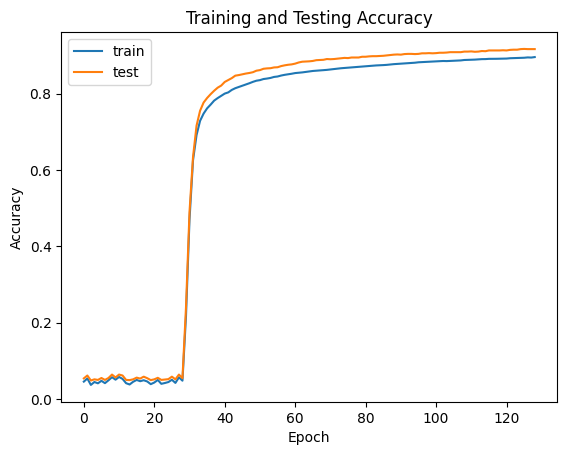

In [34]:
import numpy as np
import matplotlib.pyplot as plt  # matplotlib.pyplot 임포트 추가

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epoch')  # x축 레이블 추가
    plt.ylabel('Accuracy')  # y축 레이블 추가
    plt.title('Training and Testing Accuracy')  # 제목 추가
    plt.legend()
    plt.show()

# plot_acc 함수 호출
plot_acc(train_accuracies, test_accuracies)
